# Assignment 2 Task 2

### Introduction

This notebook presents the implementation of a recommender system using Spark MLlib's ALS (Alternating Least Squares) algorithm on the Steam-200k dataset. The objective is to build a collaborative filtering model based on implicit user feedback, where playtime is used as a proxy for user preferences. 

The task involves preprocessing the dataset, converting string identifiers into numeric indices, and applying a log transformation to normalize playtime values. The ALS model is trained and evaluated using RMSE to assess its predictive performance. Finally, top-N game recommendations are generated for each user. The entire pipeline is developed using PySpark in Databricks, with experiment tracking enabled through MLflow for transparency and reproducibility.

### Data Import and Preprocessing

In this step, firstly, the csv file or dataset was uploaded to the Databricks filestore using the Databricks GUI. Then after uploading it, I was able to view the path of my uploaded dataset using the dbutils command for listing all the files in DBFS. After that, I loaded the data into a dataframe using **spark.read.csv()** method. I have passed the filepath to my file with different paramters in it. 

In the next step, I changed all the default column names of the dataframe to specific column names (**userId**, **game**, **behavior**, and **value**). Next, I wanted to see how many unique/distinct users and games I have in my dataset, so I extracted that which shows I have 12393 unique users and 5155 unique games.

In the next step, I have grouped the data by **userId** and **game** and summed the **value** column, aliased it as **total_playtime**. This ensures that we have total play time for each **user-game** pair. Although each **(userId, game)** pair appears only once for the play behavior in this dataset, a **groupBy** with** sum()** is still used as a precaution. In practical recommender system scenarios, it's common to have multiple play logs for the same user-game pair. This aggregation step ensures data consistency and model readiness even if new duplicates are introduced in the future.

After that, I have applied **log1p** function to my **total_playtime** column to create a new column named **rating**. The purpose is to normalize the highly **skewed playtime** distribution. Since some users play certain games for hundreds of hours while others only a few, the raw values can introduce bias and instability during training. The log1p transformation compresses large values while expanding small ones, making the data more suitable for ALS training.

Now, in the next step, I am generating **numerical indices** of **userId** and **game**. We do have userIds but we didnt have it for games. So I generated for both as our ALS requires numerical indices for user and item columns. I have done that by using StringIndexer method of pyspark.ml.feature module. By assigning a unique integer to each user and each game, we enable the ALS model to build and reference latent feature matrices efficiently.





In [0]:
# MLflow is used for automatic experiment tracking
import mlflow
import mlflow.spark  # Enables Spark-specific logging within MLflow

# Importing commonly used PySpark SQL functions for data transformation and aggregation
from pyspark.sql.functions import (
    col,        # Refers to a column by name
    when,       # Conditional expressions (like SQL CASE WHEN)
    log1p,      # Computes log(1 + x), used for normalizing skewed data
    sum,        # Aggregation function to sum column values
    countDistinct,  # Counts distinct elements in a group
    count,      # Counts total records
    lit         # Creates a column with a constant literal value
)

# StringIndexer converts string categorical columns to numeric indices
from pyspark.ml.feature import StringIndexer

# ALS (Alternating Least Squares) is the collaborative filtering algorithm from Spark MLlib
from pyspark.ml.recommendation import ALS

# Used to evaluate model performance (e.g., using RMSE)
from pyspark.ml.evaluation import RegressionEvaluator

# Visualization libraries for plotting and exploratory data analysis
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [0]:
# Enables automatic logging of parameters, metrics, models, and DataFrames in MLflow
# This helps track experiments without needing to manually log each component
mlflow.autolog()

2025/04/20 20:29:43 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2025/04/20 20:29:43 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.
2025/04/20 20:29:43 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.
2025/04/20 20:29:43 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.ml.


In [0]:
# To list all the files present in the FileStor/tables folder
dbutils.fs.ls('/FileStore/tables')

[FileInfo(path='dbfs:/FileStore/tables/BDTT_Assignment_1_Enron__1_-1.zip', name='BDTT_Assignment_1_Enron__1_-1.zip', size=375294957, modificationTime=1741807669000),
 FileInfo(path='dbfs:/FileStore/tables/BDTT_Assignment_1_Enron__1_.zip', name='BDTT_Assignment_1_Enron__1_.zip', size=375294957, modificationTime=1741807253000),
 FileInfo(path='dbfs:/FileStore/tables/Clinicaltrial_16012025.csv', name='Clinicaltrial_16012025.csv', size=205522181, modificationTime=1744549171000),
 FileInfo(path='dbfs:/FileStore/tables/Occupancy_Detection_Data.csv', name='Occupancy_Detection_Data.csv', size=50968, modificationTime=1740576362000),
 FileInfo(path='dbfs:/FileStore/tables/account-models/', name='account-models/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/FileStore/tables/accounts/', name='accounts/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/FileStore/tables/activations/', name='activations/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/FileStore/tables/enron_emails/', n

In [0]:
# Reads the Steam-200k dataset from the Databricks FileStore as a CSV file
# - header=False: The file does not contain column headers
# - inferSchema=True: Automatically detects and assigns data types to each column
steam_df = spark.read.csv("/FileStore/tables/steam_200k.csv", header=False, inferSchema=True)

In [0]:
# Displays the first 10 rows of the dataframe
steam_df.show(10)

+---------+--------------------+--------+-----+
|      _c0|                 _c1|     _c2|  _c3|
+---------+--------------------+--------+-----+
|151603712|The Elder Scrolls...|purchase|  1.0|
|151603712|The Elder Scrolls...|    play|273.0|
|151603712|           Fallout 4|purchase|  1.0|
|151603712|           Fallout 4|    play| 87.0|
|151603712|               Spore|purchase|  1.0|
|151603712|               Spore|    play| 14.9|
|151603712|   Fallout New Vegas|purchase|  1.0|
|151603712|   Fallout New Vegas|    play| 12.1|
|151603712|       Left 4 Dead 2|purchase|  1.0|
|151603712|       Left 4 Dead 2|    play|  8.9|
+---------+--------------------+--------+-----+
only showing top 10 rows



In [0]:
# Renames default column names (_c0 to _c3) to meaningful, descriptive names
# _c0 → userId: Unique identifier for each user
# _c1 → game: Name of the game interacted with
# _c2 → behavior: Type of interaction ('purchase' or 'play')
# _c3 → value: Represents playtime (if 'play') or price (if 'purchase')

steam_df = steam_df.withColumnRenamed("_c0", "userId") \
                   .withColumnRenamed("_c1", "game") \
                   .withColumnRenamed("_c2", "behavior") \
                   .withColumnRenamed("_c3", "value")

In [0]:
# Displays the first 10 rows of the dataframe
steam_df.show(10)

+---------+--------------------+--------+-----+
|   userId|                game|behavior|value|
+---------+--------------------+--------+-----+
|151603712|The Elder Scrolls...|purchase|  1.0|
|151603712|The Elder Scrolls...|    play|273.0|
|151603712|           Fallout 4|purchase|  1.0|
|151603712|           Fallout 4|    play| 87.0|
|151603712|               Spore|purchase|  1.0|
|151603712|               Spore|    play| 14.9|
|151603712|   Fallout New Vegas|purchase|  1.0|
|151603712|   Fallout New Vegas|    play| 12.1|
|151603712|       Left 4 Dead 2|purchase|  1.0|
|151603712|       Left 4 Dead 2|    play|  8.9|
+---------+--------------------+--------+-----+
only showing top 10 rows



Above output shows the steam_df columns. We have userId, game, behavior and value. Behavior column shows the action of the user either he/she has purchased the game and played. Any user who played a game has also purchased that game as well. So you will see two entries for **user-game** pair. If the user has played that game as well, there will be two user-game entries, one with behavior purchase and other for play. But its not necassery that a user plays the game as well which he/she purchased. 

The **value** column shows the time a user has played the game for. It always shows 1 for the purchase behavior but it shows the actual number of hours for play behavior.

In [0]:
# Printing the shcema for the steam_df dataframe
steam_df.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- game: string (nullable = true)
 |-- behavior: string (nullable = true)
 |-- value: double (nullable = true)



In [0]:
# Defines a list of column names to analyze for uniqueness
columns = ['userId', 'game']

# Iterates through each column in the list
for col_name in columns:
    # Selects distinct (unique) values for the given column
    unique_vals = steam_df.select(col(col_name)).distinct()
    
    # Counts how many unique values exist in that column
    count = unique_vals.count()
    
    # Prints the count of unique users and unique games
    print(f"{col_name} has {count} unique values")

userId has 12393 unique values
game has 5155 unique values


In the above code, I am just printing out the distinct users and games. I just wanted to know how many unique users and games I have. So the output shows we have **12393** unique users and **5155** unique games

In [0]:
# Aggregates total playtime for each (userId, game) pair
# - Groups the data by user and game
# - Sums the 'value' column (which represents playtime when behavior is 'play')
# - Renames the aggregated column as 'total_playtime'
# This ensures that each user-game pair has a single record, even if multiple play sessions exist
steam_df = steam_df.groupBy("userId", "game").agg(sum("value").alias("total_playtime"))

In the above code, I am grouping the user and game to create the **user-game** pair and aggregating their play time just to make sure we dont have **duplicating** user-game pair. And if we have, we can group them togather and sum up their play times.
Although, we dont have duplicating values in this dataset, but keeping in view the future need if duplicating rows are added, we are gracefully handling this use case by the above piece of code.

In [0]:
# Displays the first 10 rows of the dataframe
steam_df.show(10)

+---------+--------------------+--------------+
|   userId|                game|total_playtime|
+---------+--------------------+--------------+
|151603712|         Poly Bridge|           8.5|
| 53875128|Sins of a Solar E...|           1.0|
| 53875128|Star Wars Jedi Kn...|           1.0|
| 30695285|Counter-Strike Co...|          37.0|
| 48845802|     Castle Crashers|          32.0|
| 11373749|   Dungeon Defenders|           3.3|
|164543231|No More Room in Hell|          26.0|
|109278470|Half-Life 2 Episo...|           1.5|
|  5270060|           Half-Life|           1.0|
|171847029|   Heroes & Generals|          71.0|
+---------+--------------------+--------------+
only showing top 10 rows



In above table, our **total_playtime** column shows the summed up value for each user-game pair.

In [0]:
# Applies log transformation to the total playtime to create a 'rating' column
# - log1p(x) computes log(1 + x), which handles zero values and stabilizes large ranges
# - This transformation reduces skewness in playtime data, preventing the model from being biased by extreme values
# - The resulting 'rating' is a normalized indicator of user interest for ALS training
steam_df = steam_df.withColumn("rating", log1p("total_playtime"))

In the above piece of code, I am **normalizing** the highly **skewed** playtime distribution. The reason of skeweness of playtime is because some users play game for very less hours but on the other hand some users can have playtime of more than 1000 hours, hence creating skewness in our dataset. This can create instability and biasness in our ALS model training. 

So what I have done is, I used the **log1p** function to normalize this value while creating a new **rating** column. The log1p transformation compresses large values while expanding small ones.

In [0]:
# Displays the first 10 rows of the dataframe
steam_df.show(10)

+---------+--------------------+--------------+------------------+
|   userId|                game|total_playtime|            rating|
+---------+--------------------+--------------+------------------+
|151603712|         Poly Bridge|           8.5|2.2512917986064953|
| 53875128|Sins of a Solar E...|           1.0|0.6931471805599453|
| 53875128|Star Wars Jedi Kn...|           1.0|0.6931471805599453|
| 30695285|Counter-Strike Co...|          37.0|3.6375861597263857|
| 48845802|     Castle Crashers|          32.0|3.4965075614664802|
| 11373749|   Dungeon Defenders|           3.3|1.4586150226995167|
|164543231|No More Room in Hell|          26.0| 3.295836866004329|
|109278470|Half-Life 2 Episo...|           1.5|0.9162907318741551|
|  5270060|           Half-Life|           1.0|0.6931471805599453|
|171847029|   Heroes & Generals|          71.0| 4.276666119016055|
+---------+--------------------+--------------+------------------+
only showing top 10 rows



You can see in the above output, our total_playtime has been normalized and being stored in the new rating column

In [0]:
# Initializes a StringIndexer to convert userId strings into numeric indices
# Required because ALS requires numerical user IDs
user_indexer = StringIndexer(inputCol="userId", outputCol="userIndex").fit(steam_df)

# Initializes a StringIndexer to convert game names into numeric indices
# ALS requires item (game) IDs to also be numeric
game_indexer = StringIndexer(inputCol="game", outputCol="gameIndex").fit(steam_df)

# Applies the userId-to-userIndex transformation and adds a new 'userIndex' column
steam_df = user_indexer.transform(steam_df)

# Applies the game-to-gameIndex transformation and adds a new 'gameIndex' column
steam_df = game_indexer.transform(steam_df)


2025/04/20 20:29:55 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'd9d1c56e81954b07b734a7a469fe0266', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2025/04/20 20:29:58 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '72d62ada41c445e5b49c7f51d4e04622', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow


In the above block of code, I am generating the ids for the game and user. It is important for training model using ALS to have ids for both user and item columns. Although we do have userIds but I am still generating it because these are sparse or non-continuous. Spark’s ALS model relies on dense, zero-based indexing for optimal matrix computations. To ensure efficient memory usage and internal consistency during training.  **StringIndexer** is used to convert these IDs into compact, sequential indices (userIndex and gameIndex)

Firstly, I generate the **user_indexer** and** game_indexer** using StringIndexer. It takes the column for which indexes are needed to be generated and the output column name. Then I am taking these two indexes and map it against user and game using **transform** method. So it assigns **userIndex** and **gameIndex** against each userId and game name.

In [0]:
# Displays the first 10 rows of the dataframe
steam_df.show(10)

+---------+--------------------+--------------+------------------+---------+---------+
|   userId|                game|total_playtime|            rating|userIndex|gameIndex|
+---------+--------------------+--------------+------------------+---------+---------+
|151603712|         Poly Bridge|           8.5|2.2512917986064953|    658.0|   1669.0|
| 53875128|Sins of a Solar E...|           1.0|0.6931471805599453|     11.0|    546.0|
| 53875128|Star Wars Jedi Kn...|           1.0|0.6931471805599453|     11.0|    335.0|
| 30695285|Counter-Strike Co...|          37.0|3.6375861597263857|   3211.0|     13.0|
| 48845802|     Castle Crashers|          32.0|3.4965075614664802|   1577.0|    127.0|
| 11373749|   Dungeon Defenders|           3.3|1.4586150226995167|     14.0|    179.0|
|164543231|No More Room in Hell|          26.0| 3.295836866004329|   1932.0|     25.0|
|109278470|Half-Life 2 Episo...|           1.5|0.9162907318741551|   2193.0|     38.0|
|  5270060|           Half-Life|           

Above tables shows we have added two new columns **userIndex** and **gameIndex** showing the ids of each user and game.

### Exploratory Data Analysis

In this part of the assignment, I am doing exploratory analysis of the dataset using spark functions and visualizations library like matplotlib and seaborn. Each of them I have explained below.

In [0]:
# Aggregates total playtime for each game across all users
# - Groups the DataFrame by 'game'
# - Sums the 'total_playtime' to get total hours played for each game
top_games = steam_df.groupBy("game").agg(sum("total_playtime").alias("total_playtime"))

# Orders the games by descending total playtime and displays the top 10 most played games
# - Helps identify the most popular or engaging games in the dataset
top_games.orderBy(col("total_playtime").desc()).show(10, truncate=False)

+-------------------------------------------+------------------+
|game                                       |total_playtime    |
+-------------------------------------------+------------------+
|Dota 2                                     |986525.6000000008 |
|Counter-Strike Global Offensive            |324183.6          |
|Team Fortress 2                            |175996.29999999993|
|Counter-Strike                             |135117.09999999995|
|Sid Meier's Civilization V                 |100417.29999999999|
|Counter-Strike Source                      |97053.50000000001 |
|The Elder Scrolls V Skyrim                 |71606.29999999999 |
|Garry's Mod                                |50456.3           |
|Call of Duty Modern Warfare 2 - Multiplayer|42352.899999999994|
|Left 4 Dead 2                              |34547.7           |
+-------------------------------------------+------------------+
only showing top 10 rows



In the above code, I am showing the top 10 games by their playtime. The results show which are the top 10 games who are played most. 
For finding out this, firstly I grouped my data by the game and applied aggregation sum function on the **total_playtime**. What it does is, it groups the all the games with same name and then adds up their playtime. I have created a new column for it and named that column as total_playtime, which shows the summed amount of play time.

After that, I am just sorting the results in descending order and limiting my results to only 10 which make sure we have the top 10 games. The results show that the **Dota 2** is the most played game with around **986525** hours playing time. 

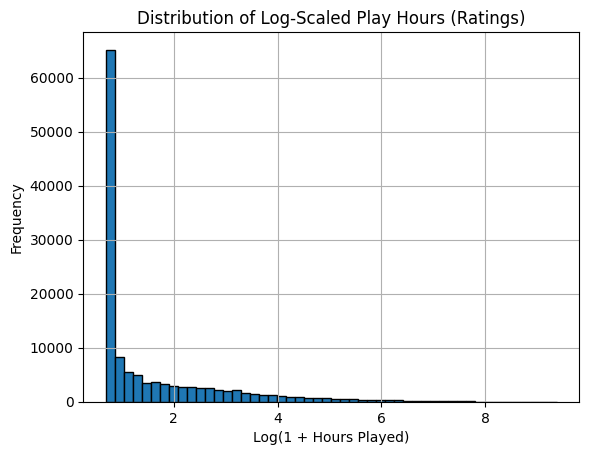

In [0]:
# Distribution of playtime (log-scaled ratings)

# Converts the 'rating' column from the Spark DataFrame to a Pandas DataFrame
# - Required because matplotlib (used for plotting) works with Pandas or NumPy
ratings_pd = steam_df.select("rating").toPandas()

# Plots a histogram to visualize how log-scaled playtime values are distributed
# - bins=50: Divides the x-axis into 50 intervals
# - edgecolor='black': Outlines each bar for better visual separation
plt.hist(ratings_pd["rating"], bins=50, edgecolor='black')

# Adds a title and axis labels to the histogram
plt.title("Distribution of Log-Scaled Play Hours (Ratings)")
plt.xlabel("Log(1 + Hours Played)")
plt.ylabel("Frequency")

# Displays a grid for easier readability of value distribution
plt.grid(True)

# Renders the plot
plt.show()


After applying the log1p transformation to the total playtime values, I wanted to verify whether this step actually helped normalize the distribution of the data. To explore this, I created a histogram of the log-scaled playtime values (now treated as ratings). This visualization helps me better understand how the data is distributed after transformation. As shown in the plot, most user-game interactions fall within the lower log-scaled range, with frequency gradually tapering off as the values increase. This confirms that the log1p function worked as intended — reducing the skewness without completely flattening the data.

To achieve this, I begin by converting the rating column (which holds log-transformed playtime values) from a Spark DataFrame to a Pandas DataFrame using **.toPandas()**, since visualization libraries like matplotlib require data in Pandas or NumPy format. I then use **plt.hist()** to create a histogram of these values, setting bins=50 to divide the range into fine intervals for better granularity, and edgecolor='black' to clearly outline each bar for visual clarity. The plot is titled "Distribution of Log-Scaled Play Hours (Ratings)" to describe what is being visualized, and the axes are labeled accordingly: the x-axis shows log(1 + hours played) — representing user engagement — and the y-axis shows the frequency of these values. A grid is added with **plt.grid(True)** to make it easier to visually trace values across the plot. Finally, **plt.show()** renders the plot, helping me assess how well the log transformation normalized the playtime distribution and whether further preprocessing is needed.

In [0]:
from pyspark.sql.functions import count
# Groups the dataset by 'game' to calculate two key engagement metrics:
# - num_users: Number of unique user-game interactions (i.e., how many users played each game)
# - total_hours: Total playtime accumulated across all users for each game
game_user_counts = steam_df.groupBy("game").agg(
    count("userId").alias("num_users"),
    sum("total_playtime").alias("total_hours")
)

# Orders the games by number of users in descending order and selects the top 10 most-played games by user count
# Converts the result to a Pandas DataFrame for easy visualization or export
top10_games = game_user_counts.orderBy(col("num_users").desc()).limit(10).toPandas()


In this step, I wanted to identify the top 10 games in the dataset that attracted the highest number of players(users). So firstly, I am grouping the data by game and then I am counting how many users have played that specific game the summing up the total played hours. After that, I am just sorting the results on num_users in descending order and limiting the results to 10.

This extraction of the above data is being used in the plot drawn below to visualize it. 

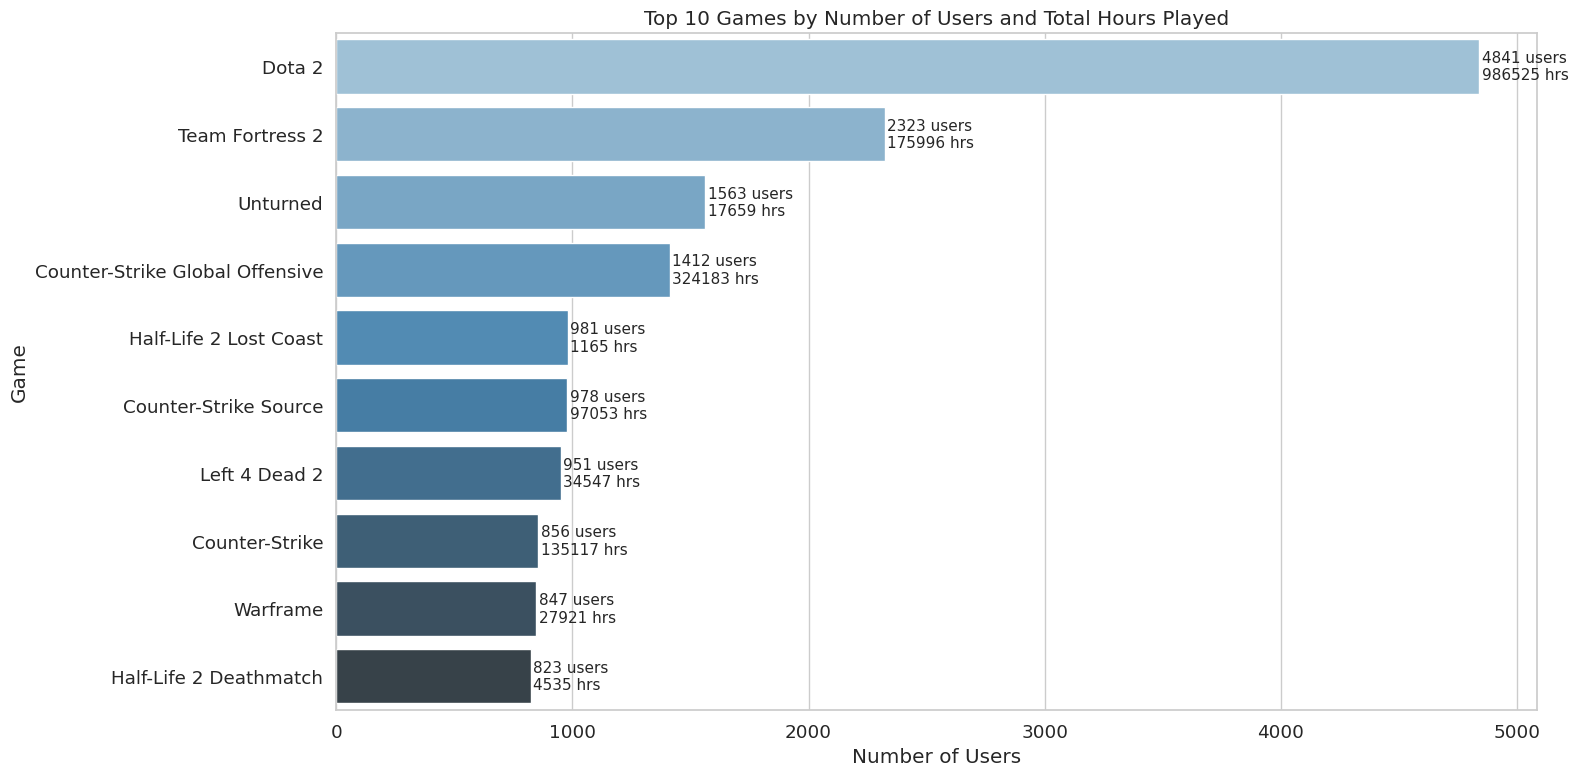

In [0]:
# Set the figure size for the plot
plt.figure(figsize=(16, 8))

# Set seaborn style and font scale for consistent formatting
sns.set(style="whitegrid", font_scale=1.2)

# Create a horizontal bar plot showing number of users per game
# - x-axis: number of users
# - y-axis: game names
# - palette: 'Blues_d' adds a gradient blue color for aesthetics
ax = sns.barplot(data=top10_games, y="game", x="num_users", palette="Blues_d")

# Annotate each bar with both the number of users and total hours played
for index, row in top10_games.iterrows():
    # Extract number of users for the game
    users = int(row["num_users"])
    # Extract total hours played for the game
    hours = int(row["total_hours"])
    # Place the annotation slightly to the right of the bar
    ax.text(users + 10, index, f"{users} users\n{hours} hrs", va="center", fontsize=11)

# Add title and axis labels for clarity
plt.title("Top 10 Games by Number of Users and Total Hours Played")
plt.xlabel("Number of Users")
plt.ylabel("Game")

# Automatically adjust subplot params for a clean layout
plt.tight_layout()

# Render the plot
plt.show()

The above plot shows the top 10 games along with the number of played hours and users. On y-axis, there is are game names and on x-axis there are number of users. SO you can see the trend, as the number of users or players increase, the play time increases. 

We can see **Dota 2** is most played game along with most players/users.

### Model Training

In this part of the assignment, I trained a recommendation model using Spark MLlib's ALS (**Alternating Least Squares**) algorithm, which is widely used for collaborative filtering.

I used explicit feedback version of ALS by considereing play time as rating. Intially, I split my dataset into two parts. One for the training purpose and other one is for testing my model. After that I made the predictions on my test data.

In [0]:
# Splits the dataset into training and test sets using an 80/20 ratio
# - training_data: used to train the ALS model
# - test_data: used to evaluate model performance on unseen data
# - seed=100 ensures reproducibility of the random split
(training_data, test_data) = steam_df.randomSplit([0.8, 0.2], seed=100)

In [0]:
# Initialize the ALS (Alternating Least Squares) model
# - userCol: column representing indexed user IDs
# - itemCol: column representing indexed game IDs
# - ratingCol: column with interaction strength (log-scaled playtime)
# - nonnegative: ensures predicted ratings are ≥ 0
# - implicitPrefs: set to False for explicit feedback (we're using ratings)
# - coldStartStrategy: drops unseen user/item pairs during predictions to avoid NaNs
# - maxIter: number of ALS training iterations
# - regParam: regularization term to reduce overfitting
# - rank: number of latent features to learn
# - seed: ensures reproducibility
als = ALS(
    userCol="userIndex",
    itemCol="gameIndex",
    ratingCol="rating",
    nonnegative=True,
    implicitPrefs=False,
    coldStartStrategy="drop",
    maxIter=15,
    regParam=0.1,
    rank=10,
    seed=100
)

# Train the ALS model on the training dataset
model = als.fit(training_data)


2025/04/20 20:30:12 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '6e86ec32dc254b19b2f2636850e12580', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2025/04/20 20:30:13 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/databricks/python/lib/python3.10/site-packages/mlflow/data/spark_dataset.py:159: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missi

In the above code, there is a ALS configuration in which userCol was set to "**userIndex**" and itemCol to "**gameIndex**", both of which were generated using StringIndexer to ensure the model received compact, zero-based integer indices as required.

I filtered the dataset beforehand to include only "**play**" behavior entries. This decision was intentional — I wanted the model to focus on real engagement (i.e., time spent playing) rather than purchases, which may not always reflect interest or satisfaction. Therefore, the itemCol in this context refers to games played, not purchased.

In the end, I trained my data using **.fit()** method and put my training data in it and stored in the a **model** variable.

In [0]:
# Generating the predictions on my test dataset
predictions = model.transform(test_data)


In [0]:
predictions.display()

userId game total_playtime rating userIndex gameIndex prediction 5250 Day of Defeat 1.0 0.6931471805599453 1194 21 0.64048815 76767 Call of Duty Black Ops - Multiplayer 13.5 2.6741486494265287 725 70 2.9184737 76767 Counter-Strike Source 26.0 3.295836866004329 725 5 2.8594434 86540 Audiosurf 58.0 4.07753744390572 320 281 1.2305241 86540 Deus Ex Invisible War 1.0 0.6931471805599453 320 429 0.48095834 86540 Puzzle Agent 2 1.0 0.6931471805599453 320 1020 0.5553425 86540 Team Fortress Classic 1.0 0.6931471805599453 320 37 0.52260923 86540 The Elder Scrolls V Skyrim - Dawnguard 1.0 0.6931471805599453 320 34 0.4211699 86540 Tom Clancy's Ghost Recon Advanced Warfighter 1.2 0.7884573603642702 320 2634 1.0439752 86540 Tom Clancy's Ghost Recon Advanced Warfighter 2 1.0 0.6931471805599453 320 1968 0.53911936 103360 Counter-Strike 1.0 0.6931471805599453 2019 7 0.745789 103360 Counter-Strike Condition Zero 1.0 0.6931471805599453 2019 13 0.66034245 229911 Team Fortress Classic 1.0 0.6931471805599453 955 37 0.7602384 298950 BioShock Infinite 22.0 3.1354942159291497 45 53 2.00983 298950 Borderlands 2 79.0 4.382026634673881 45 26 3.6077237 298950 DARK SOULS II Crown of the Old Iron King 1.0 0.6931471805599453 45 901 0.63810486 298950 Gish 1.0 0.6931471805599453 45 939 0.8061512 298950 Just Cause 2 2.6 1.2809338454620645 45 77 1.806415 298950 Metro Last Light 10.8 2.468099531471619 45 246 1.8897622 298950 Prison Architect 3.4 1.4816045409242156 45 209 1.6688771 298950 RAGE 13.2 2.653241964607215 45 294 1.9385974 298950 Rust 40.0 3.713572066704308 45 99 3.101353 298950 Surgeon Simulator 1.8 1.0296194171811583 45 230 1.1024562 298950 Torchlight 10.2 2.4159137783010487 45 268 1.8813207 298950 Tower of Guns 1.0 0.6931471805599453 45 1875 0.86142594 298950 Unturned 4.5 1.7047480922384253 45 2 2.0664473 381543 Counter-Strike Condition Zero 1.0 0.6931471805599453 2136 13 0.6859369 381543 Counter-Strike Condition Zero Deleted Scenes 1.0 0.6931471805599453 2136 14 0.5034382 554278 Half-Life Deathmatch Source 1.0 0.6931471805599453 920 61 0.5266733 554278 Mare Nostrum 1.0 0.6931471805599453 920 432 0.605565 554278 Ricochet 1.0 0.6931471805599453 920 23 0.57025284 561758 Borderlands DLC Claptraps New Robot Revolution 1.0 0.6931471805599453 142 194 0.6097442 561758 Call of Duty Modern Warfare 2 - Multiplayer 52.0 3.970291913552122 142 45 3.0619922 561758 Day of Defeat 2.7 1.308332819650179 142 21 1.2502897 561758 Deathmatch Classic 1.0 0.6931471805599453 142 22 0.75006753 561758 Medal of Honor Pre-Order 1.0 0.6931471805599453 142 217 0.64909047 561758 Section 8 Prejudice 2.7 1.308332819650179 142 1508 1.5340198 561758 Shattered Union 1.0 0.6931471805599453 142 2898 1.3516116 561758 Stronghold Crusader Extreme HD 1.0 0.6931471805599453 142 600 0.7432524 748719 Brothers in Arms Road to Hill 30 4.9 1.7749523509116738 871 2456 2.0541108 871990 Day of Defeat 1.2 0.7884573603642702 1891 21 0.7098087 871990 Deathmatch Classic 1.0 0.6931471805599453 1891 22 0.5958365 948368 Deathmatch Classic 1.0 0.6931471805599453 1670 22 0.5258665 975449 A Valley Without Wind 2 1.5 0.9162907318741551 25 1779 0.7488725 975449 Amnesia The Dark Descent 27.0 3.332204510175204 25 87 1.1697948 975449 Blocks That Matter 8.5 2.2512917986064953 25 1122 1.190438 975449 Borderlands DLC The Zombie Island of Dr. Ned 1.0 0.6931471805599453 25 172 0.61656296 975449 Braid 4.5 1.7047480922384253 25 338 1.1677928 975449 Brothers - A Tale of Two Sons 1.0 0.6931471805599453 25 418 1.0350393 975449 Cities XL Platinum 1.2 0.7884573603642702 25 739 0.98084444 975449 Day of Defeat 1.0 0.6931471805599453 25 21 0.8566185 975449 Day of Defeat Source 5.1 1.8082887711792655 25 28 1.1798607 975449 Fate of the World 1.5 0.9162907318741551 25 2028 1.0397112 975449 Half-Life Blue Shift 3.9 1.589235205116581 25 40 0.817105 975449 King's Bounty Armored Princess 3.3 1.4586150226995167 25 1365 0.90514046 975449 King's Bounty Crossworlds 3.5 1.5040773967762742 25 1427 1.0323118 975449 Poker Night at the Inventory 2.

The above table is the prediction table. Basically it is the same table as we had for steam_df but with the added column of prediction. What this prediction column tells us is how likely it is that the user will like the given game. The higher this number is, it is more likely the user will like to play that game.

### Model Evaluation

In this part, I am evaluating my model. I evaluated its performance using Root Mean Squared Error (**RMSE**), which is a standard metric for assessing the accuracy of predicted ratings in recommendation systems. RMSE measures the average difference between the predicted and actual ratings in the test set — lower values indicate better predictive accuracy.

In [0]:
# Initialize a regression evaluator to measure prediction error using RMSE (Root Mean Squared Error)
# - labelCol: the actual rating values (log-scaled playtime)
# - predictionCol: the predicted rating values generated by the ALS model
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

# Compute RMSE by comparing predicted ratings with actual ratings on the test dataset
rmse = evaluator.evaluate(predictions)

I first initiated the evaluator using RegressionEvaluator where I put the metric name to be rmse, labelCol to be rating and prediction column to be prediction.
Then I used the **evaluate()** method and put in my predictions.

In [0]:
print(rmse)

0.7107119470868027


I got printed my rmse value which is **0.7107**. So this means our prediction values are pretty accurate but we can reduce them by hyperparameter tuning.

### Hyperparameter Tuning

In this section, I explored the impact of hyperparameter choices on the ALS model’s performance. Since ALS is a matrix factorization algorithm, certain parameters play a critical role in determining how well it captures latent patterns in user-item interactions.

I tuned two most important parameters which are **Rank** and **RegParams**. Rank basically controls the number of latent features (factors) the model learns. A higher rank allows the model to capture more complex patterns, but may lead to overfitting. RegParam is the regularization parameter that helps control overfitting by penalizing overly complex models.

After tuning, it gives me the best model based on the provided paramters and then I replace my model with the best one and start making predictions using that model.

In [0]:
# Define lists of values to test for 'rank' (latent factors) and 'regParam' (regularization)
ranks = [8, 10, 12]
regParams = [0.01, 0.05, 0.1]

# Initialize variables to track the best RMSE, best model, and best parameter combination
best_rmse = float("inf")
best_model = None
best_params = {}

# Loop through all combinations of rank and regParam
for rank in ranks:
    for reg in regParams:
        # Configure ALS model with current parameter combination
        als = ALS(
            userCol="userIndex",
            itemCol="gameIndex",
            ratingCol="rating",
            nonnegative=True,
            implicitPrefs=False,
            coldStartStrategy="drop",
            rank=rank,
            regParam=reg,
            maxIter=15,
            seed=100
        )

        # Train the ALS model on the training data
        model = als.fit(training_data)

        # Generate predictions on the test data
        predictions = model.transform(test_data)

        # Evaluate predictions using RMSE
        rmse = evaluator.evaluate(predictions)

        # Print current combination and corresponding RMSE
        print(f"Rank: {rank}, RegParam: {reg}, RMSE: {rmse}")

        # Update best model if current RMSE is lower than the best so far
        if rmse < best_rmse:
            best_rmse = rmse
            best_model = model
            best_params = {"rank": rank, "regParam": reg}

# Display the best RMSE achieved and the corresponding parameters
print("Best RMSE:", best_rmse)
print("Best Parameters:", best_params)


2025/04/20 20:32:45 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '87b2520c1f79452cb1a116dc37784e3e', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2025/04/20 20:34:49 WARNING mlflow.pyspark.ml: Model ALS_75c516722a08 will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


Rank: 8, RegParam: 0.01, RMSE: 0.7264038691126482


2025/04/20 20:35:14 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'd6e2cf183d954088bdb936a76293255e', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2025/04/20 20:37:19 WARNING mlflow.pyspark.ml: Model ALS_06de4194c0c8 will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


Rank: 8, RegParam: 0.05, RMSE: 0.7071068378911703


2025/04/20 20:37:44 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '5669cea0f25a44938394b5358495e1a1', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2025/04/20 20:39:54 WARNING mlflow.pyspark.ml: Model ALS_9a72d79f439f will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


Rank: 8, RegParam: 0.1, RMSE: 0.7341725284537914


2025/04/20 20:40:20 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '755665509b8f420eb3c59a9e7e6a90de', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2025/04/20 20:42:36 WARNING mlflow.pyspark.ml: Model ALS_fbe1dca6b796 will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


Rank: 10, RegParam: 0.01, RMSE: 0.7106002898672659


2025/04/20 20:43:02 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '98ebb0ba3eba4f7480889dcfd54c31a6', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2025/04/20 20:45:19 WARNING mlflow.pyspark.ml: Model ALS_b4da2f87a30d will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


Rank: 10, RegParam: 0.05, RMSE: 0.6871787425612946


2025/04/20 20:45:47 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '3fb1b27231ca4dfb8b5de1395763fa90', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2025/04/20 20:48:07 WARNING mlflow.pyspark.ml: Model ALS_c050525d203f will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


Rank: 10, RegParam: 0.1, RMSE: 0.7107119470868027


2025/04/20 20:48:33 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '9a16e8cb587e48bbbce7cffd7cd69314', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2025/04/20 20:50:57 WARNING mlflow.pyspark.ml: Model ALS_0cca01501846 will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


Rank: 12, RegParam: 0.01, RMSE: 0.6879799170416826


2025/04/20 20:51:25 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '74f237b5524a43bcb60f03a0c81fa1b8', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2025/04/20 20:53:47 WARNING mlflow.pyspark.ml: Model ALS_a02dd136e83b will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


Rank: 12, RegParam: 0.05, RMSE: 0.6725256402951776


2025/04/20 20:54:15 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'e472aea0c0374be88abb8208e8ded099', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2025/04/20 20:56:38 WARNING mlflow.pyspark.ml: Model ALS_7cc3db2211a3 will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


Rank: 12, RegParam: 0.1, RMSE: 0.7050775697414342
Best RMSE: 0.6725256402951776
Best Parameters: {'rank': 12, 'regParam': 0.05}


Above code is bascially tuning my hyperparamters. Intially, I define array of both rank and regParam. I pass values to it and then I make a nested for loop to loop through each of these values and find the best combination which will return me the best rmse. 

In each loop, combination of my values are made, on each loop, model is being trained on training data and the prediction are made using that model on test data. And then the evaluator part comes which evaluates my predictions.

Then I have a if else statement, which compares the rmse with the previous rmse. If it is less then before, then we store that in new variable named best_rmse and set our model to best_model variable and print the best_rmse along with the 

I used MLflow to log key hyperparameters **(rank, regParam)** and model performance **(rmse)** for each combination. This allowed me to monitor and compare the effect of different parameter settings on model accuracy and identify the best-performing configuration. 

In [0]:
# Making predictions using best model on test_data
predictions = best_model.transform(test_data)
predictions.display()

userId game total_playtime rating userIndex gameIndex prediction 5250 Day of Defeat 1.0 0.6931471805599453 1194 21 1.5561582 76767 Call of Duty Black Ops - Multiplayer 13.5 2.6741486494265287 725 70 2.7182097 76767 Counter-Strike Source 26.0 3.295836866004329 725 5 2.826208 86540 Audiosurf 58.0 4.07753744390572 320 281 1.8029029 86540 Deus Ex Invisible War 1.0 0.6931471805599453 320 429 0.551093 86540 Puzzle Agent 2 1.0 0.6931471805599453 320 1020 0.69145906 86540 Team Fortress Classic 1.0 0.6931471805599453 320 37 0.54192406 86540 The Elder Scrolls V Skyrim - Dawnguard 1.0 0.6931471805599453 320 34 0.4559505 86540 Tom Clancy's Ghost Recon Advanced Warfighter 1.2 0.7884573603642702 320 2634 0.81474054 86540 Tom Clancy's Ghost Recon Advanced Warfighter 2 1.0 0.6931471805599453 320 1968 0.5985578 103360 Counter-Strike 1.0 0.6931471805599453 2019 7 0.71514255 103360 Counter-Strike Condition Zero 1.0 0.6931471805599453 2019 13 0.6879182 229911 Team Fortress Classic 1.0 0.6931471805599453 955 37 0.6267988 298950 BioShock Infinite 22.0 3.1354942159291497 45 53 2.370429 298950 Borderlands 2 79.0 4.382026634673881 45 26 3.2830257 298950 DARK SOULS II Crown of the Old Iron King 1.0 0.6931471805599453 45 901 0.6623306 298950 Gish 1.0 0.6931471805599453 45 939 0.9007888 298950 Just Cause 2 2.6 1.2809338454620645 45 77 2.2872844 298950 Metro Last Light 10.8 2.468099531471619 45 246 2.3768618 298950 Prison Architect 3.4 1.4816045409242156 45 209 1.6718765 298950 RAGE 13.2 2.653241964607215 45 294 1.9050028 298950 Rust 40.0 3.713572066704308 45 99 2.4031653 298950 Surgeon Simulator 1.8 1.0296194171811583 45 230 1.1737559 298950 Torchlight 10.2 2.4159137783010487 45 268 1.774803 298950 Tower of Guns 1.0 0.6931471805599453 45 1875 0.82634735 298950 Unturned 4.5 1.7047480922384253 45 2 1.6870273 381543 Counter-Strike Condition Zero 1.0 0.6931471805599453 2136 13 0.6954045 381543 Counter-Strike Condition Zero Deleted Scenes 1.0 0.6931471805599453 2136 14 0.5968766 554278 Half-Life Deathmatch Source 1.0 0.6931471805599453 920 61 0.57829195 554278 Mare Nostrum 1.0 0.6931471805599453 920 432 0.6805345 554278 Ricochet 1.0 0.6931471805599453 920 23 0.4970111 561758 Borderlands DLC Claptraps New Robot Revolution 1.0 0.6931471805599453 142 194 0.6485071 561758 Call of Duty Modern Warfare 2 - Multiplayer 52.0 3.970291913552122 142 45 2.915568 561758 Day of Defeat 2.7 1.308332819650179 142 21 1.5972631 561758 Deathmatch Classic 1.0 0.6931471805599453 142 22 0.7901823 561758 Medal of Honor Pre-Order 1.0 0.6931471805599453 142 217 0.75970006 561758 Section 8 Prejudice 2.7 1.308332819650179 142 1508 1.4149945 561758 Shattered Union 1.0 0.6931471805599453 142 2898 0.8543154 561758 Stronghold Crusader Extreme HD 1.0 0.6931471805599453 142 600 0.8827579 748719 Brothers in Arms Road to Hill 30 4.9 1.7749523509116738 871 2456 0.37335354 871990 Day of Defeat 1.2 0.7884573603642702 1891 21 0.70078313 871990 Deathmatch Classic 1.0 0.6931471805599453 1891 22 0.59627646 948368 Deathmatch Classic 1.0 0.6931471805599453 1670 22 0.62850773 975449 A Valley Without Wind 2 1.5 0.9162907318741551 25 1779 0.822565 975449 Amnesia The Dark Descent 27.0 3.332204510175204 25 87 1.263985 975449 Blocks That Matter 8.5 2.2512917986064953 25 1122 1.3408815 975449 Borderlands DLC The Zombie Island of Dr. Ned 1.0 0.6931471805599453 25 172 0.6644353 975449 Braid 4.5 1.7047480922384253 25 338 1.2325693 975449 Brothers - A Tale of Two Sons 1.0 0.6931471805599453 25 418 1.2602292 975449 Cities XL Platinum 1.2 0.7884573603642702 25 739 1.2984631 975449 Day of Defeat 1.0 0.6931471805599453 25 21 0.73074776 975449 Day of Defeat Source 5.1 1.8082887711792655 25 28 1.127924 975449 Fate of the World 1.5 0.9162907318741551 25 2028 0.9722818 975449 Half-Life Blue Shift 3.9 1.589235205116581 25 40 0.775982 975449 King's Bounty Armored Princess 3.3 1.4586150226995167 25 1365 1.0118401 975449 King's Bounty Crossworlds 3.5 1.5040773967762742 25 1427 1.2625417 975449 Poker Night at the Inventory 2.3 

In [0]:
# Evaluation of the model
rmse = evaluator.evaluate(predictions)
print(f"Final RMSE on Test Data: {rmse}")

Final RMSE on Test Data: 0.6725256402951776


This is the lowest rmse I generated after the hyperparameter tuning. As you can see when we first trained our model we had **0.710** rmse but after tuning, I reduced it to **0.6725**

### Generating Recommendations

After training the model and tunning the hyperparamters, now its time to generate the game recommendations for the user. In the section I will be covering this.

In [0]:
# Generate top 10 personalized game recommendations for every user in the dataset
# - The result includes a list of (gameIndex, predicted_rating) pairs for each user
# - These are items the user hasn't interacted with but is likely to enjoy based on the model
user_recs = best_model.recommendForAllUsers(10)

# Display the full list of recommendations without truncating long rows
# - Helps view all gameIndex–rating pairs for each user
user_recs.show(truncate=False)

+---------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|userIndex|recommendations                                                                                                                                                                           |
+---------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|26       |[{4652, 3.8216116}, {3723, 3.282582}, {4905, 3.2261977}, {145, 3.1988485}, {239, 3.0103714}, {324, 2.9251204}, {3038, 2.8845081}, {3, 2.8577728}, {330, 2.8268278}, {141, 2.802697}]      |
|27       |[{3723, 3.8512595}, {4652, 3.657404}, {59, 3.346895}, {876, 3.3387303}, {3038, 3.3229349}, {239, 3.2213755}, {1007, 3.218004}, {391, 3.1795046}, {324, 3.167583}, {4331, 3.1021643}]      |
|28  

In the above code, I am using my **best_model** and using **recommendForAllUsers** method to generate the recommendations for all the users. I am passing 10 parameter which means only recommend the top 10 games.

The output shows the **userIndex** along with array of objects where each object consists of **gameIndex** and its **predicted** rating. So each user is being recommended top 10 games specifically based on its liking.

In [0]:
# Recommend top 10 games for a specific user (e.g., userIndex = 42)
user_id = 42

# Create a subset DataFrame containing only the selected user
# - Ensures that recommendForUserSubset receives a DataFrame, as required
user_subset = steam_df.filter(col("userIndex") == user_id).select("userIndex").distinct()

# Generate top 10 personalized recommendations for the specified user
# - Returns (gameIndex, predicted_rating) pairs for items the user hasn't interacted with
recommendations = best_model.recommendForUserSubset(user_subset, 10)

# Display the full list of recommendations without truncating long rows
recommendations.show(truncate=False)


+---------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|userIndex|recommendations                                                                                                                                                                 |
+---------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|42       |[{4652, 5.438058}, {4331, 4.144634}, {24, 4.0953426}, {3038, 4.092919}, {1275, 4.083987}, {1135, 4.069019}, {17, 4.059978}, {339, 3.9723916}, {11, 3.8849902}, {764, 3.7485986}]|
+---------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+



The above code is also generating recommendations but this time it is specifically generating for the user with userIndex of 42.

### Conclusion

In this assignment, I successfully built and evaluated a personalized game recommendation system using Spark’s ALS algorithm on the Steam-200k dataset. Through data preprocessing, log transformation, and hyperparameter tuning, the model was able to generate accurate and relevant recommendations based on user playtime behavior.